In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_df = pd.read_csv('train.csv')

In [9]:
test_df = pd.read_csv('test.csv')

In [7]:
train_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [11]:
test_df.head()

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0


C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  plt.tight_layout();
C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from current font.
  plt.tight_layout();
C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from current font.
  plt.tight_layout();
C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  plt.tight_layout();
C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout();
C:\Users\user\AppData\Local\Temp\ipykernel_25280\78720637.py:2: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  plt.tight_layout();
C:\Users\user\A

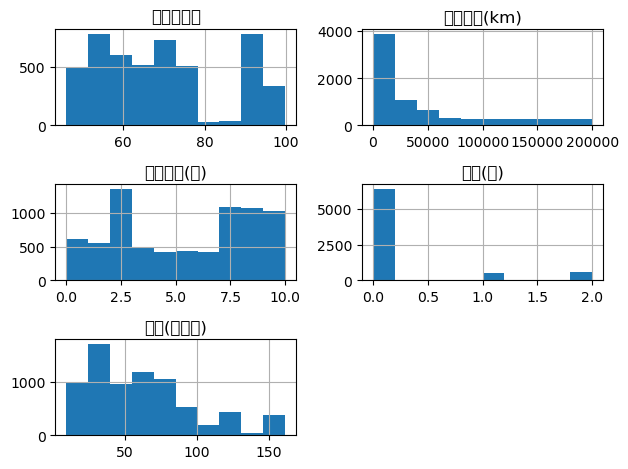

In [15]:
train_df.hist()
plt.tight_layout();